In [2]:
import torch
import torch.nn as nn
import torchvision
from torchvision import models, transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [3]:
device = torch.device(torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu"))

In [29]:
def get_image(path, img_transform, size=(300, 300)):
    image = Image.open(path)
    image = image.resize(size, Image.LANCZOS)
    image = img_transform(image).unsqueeze(0)
    return image.to(device)

def get_gram(m):
    '''
    m is of shape (1, C, H, W)
    '''
    _, c, h, w = m.size()
    m = m.view(c, h * w)
    m = torch.mm(m, m.t())
    return m

def denormalize_img(inp):
    # PyTorch has image format (C, H, W)
    # Numpy has image format (H, W, C)
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    inp = inp * std + mean
    inp = np.clip(inp, 0, 1)

    return inp

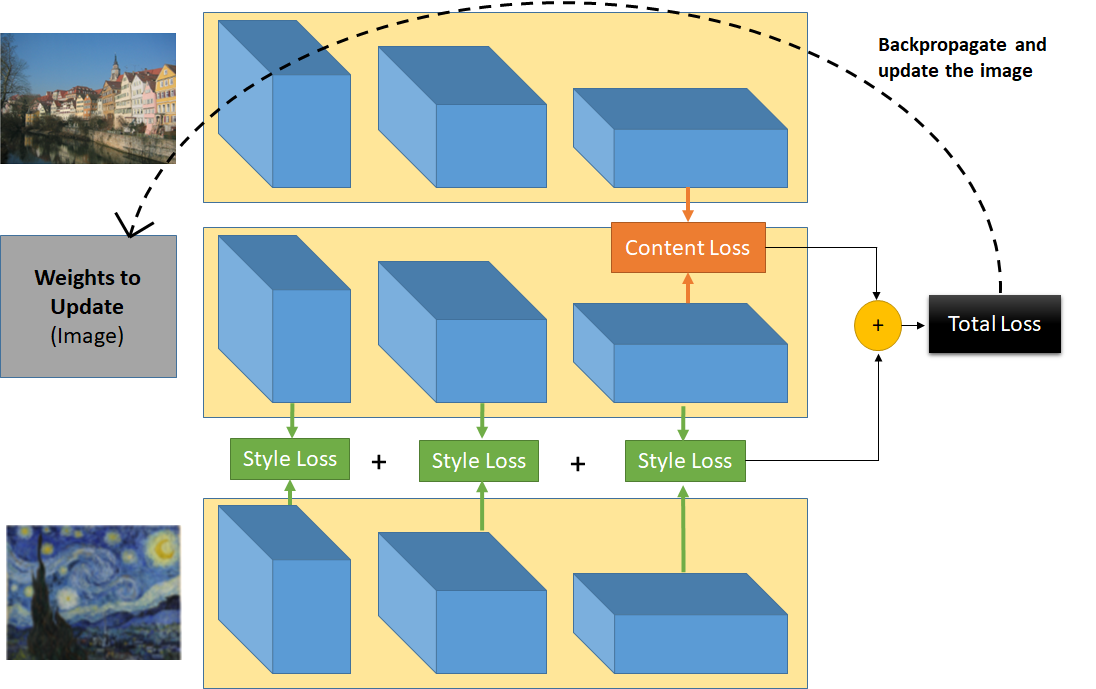

In [11]:
class FeatureExtractor(nn.Module):
    def __init__(self):
        super(FeatureExtractor, self).__init__()
        self.selected_layers = [3, 8, 15, 22]  # It is expensive to compute style loss at each layers, hence we selected only these layers
        self.vgg = models.vgg16(weights=torchvision.models.VGG16_Weights.DEFAULT).features

    def forward(self, x):
        layer_feats = []

        for layer_num, layer in self.vgg._modules.items():
            x = layer(x)
            if int(layer_num) in self.selected_layers:
                layer_feats.append(x)
        
        return layer_feats

In [51]:
img_transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
        ])

content_img = get_image('data/style.jpeg', img_transform)
style_img = get_image('data/content.jpeg', img_transform)

generated_img = content_img.clone()  # Start from the content image and then apply the styles on it
generated_img.requires_grad = True  # To allow training and backpropogation

optimizer = torch.optim.Adam([generated_img], lr=0.003, betas=[0.5, 0.999])
encoder = FeatureExtractor().to(device)

# Can also do encoder.eval()
for p in encoder.parameters():
    p.requires_grad = False

In [58]:
content_weight = 1
style_weight = 100

for epoch in range(5000):
    content_features = encoder(content_img)
    style_features = encoder(style_img)
    generated_features = encoder(generated_img)

    content_loss = torch.mean((content_features[-1] - generated_features[-1])**2)  # Getting the MSE

    style_loss = 0
    for gf, sf in zip(generated_features, style_features):
        _, c, h, w = gf.size()
        gram_gf = get_gram(gf)
        gram_sf = get_gram(sf)
        style_loss += torch.mean((gram_gf - gram_sf)**2) / (c * h * w)

    loss = content_weight * content_loss + style_weight * style_loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print('Epoch [{}]\tContent Loss:{:.4f}\tStyle Loss:{:.4f}'.format(epoch, content_loss.item(), style_loss.item()))

Epoch [0]	Content Loss:4.1865	Style Loss:18.8565
Epoch [10]	Content Loss:4.1891	Style Loss:18.6972
Epoch [20]	Content Loss:4.1914	Style Loss:18.5395
Epoch [30]	Content Loss:4.1942	Style Loss:18.3834
Epoch [40]	Content Loss:4.1970	Style Loss:18.2289
Epoch [50]	Content Loss:4.1998	Style Loss:18.0761
Epoch [60]	Content Loss:4.2025	Style Loss:17.9247
Epoch [70]	Content Loss:4.2048	Style Loss:17.7749
Epoch [80]	Content Loss:4.2070	Style Loss:17.6268
Epoch [90]	Content Loss:4.2096	Style Loss:17.4801
Epoch [100]	Content Loss:4.2121	Style Loss:17.3348
Epoch [110]	Content Loss:4.2147	Style Loss:17.1910
Epoch [120]	Content Loss:4.2178	Style Loss:17.0485
Epoch [130]	Content Loss:4.2202	Style Loss:16.9075
Epoch [140]	Content Loss:4.2228	Style Loss:16.7680
Epoch [150]	Content Loss:4.2252	Style Loss:16.6297
Epoch [160]	Content Loss:4.2276	Style Loss:16.4928
Epoch [170]	Content Loss:4.2310	Style Loss:16.3572
Epoch [180]	Content Loss:4.2346	Style Loss:16.2229
Epoch [190]	Content Loss:4.2374	Style Loss

In [59]:
inp = generated_img.detach().cpu().squeeze()

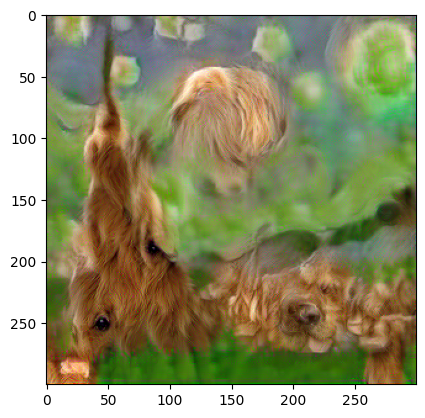

In [60]:
inp = denormalize_img(inp)
plt.imshow(inp)